In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import evaluate
import env

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = wrangle.get_zillow_data()
df.head()

,lot_id,total_rooms,bedrooms,bathrooms,garages,pools,area,lot_size,fips,county,city,zip,yearbuilt,tax_value
0,14297519,0.0,4.0,3.5,2.0,NaN,3100.0,4506.0,6059.0,1286.0,53571.0,96978.0,1998.0,1023282.0
1,17052889,5.0,2.0,1.0,1.0,NaN,1465.0,12647.0,6111.0,2061.0,13091.0,97099.0,1967.0,464000.0
2,14186244,6.0,3.0,2.0,2.0,1.0,1243.0,8432.0,6059.0,1286.0,21412.0,97078.0,1962.0,564778.0
3,12177905,0.0,4.0,3.0,NaN,1.0,2376.0,13038.0,6037.0,3101.0,396551.0,96330.0,1970.0,145143.0
4,12095076,0.0,4.0,3.0,NaN,1.0,2962.0,63000.0,6037.0,3101.0,47019.0,96293.0,1950.0,773303.0


In [3]:
df2 = df.drop(columns = ['lot_id', 'total_rooms', 'garages', 'pools', 'lot_size', 'fips', 'county', 'city', 'zip', 'yearbuilt'])
df2.head()

,bedrooms,bathrooms,area,tax_value
0,4.0,3.5,3100.0,1023282.0
1,2.0,1.0,1465.0,464000.0
2,3.0,2.0,1243.0,564778.0
3,4.0,3.0,2376.0,145143.0
4,4.0,3.0,2962.0,773303.0


In [4]:
df2.isnull().any()

bedrooms     False
bathrooms    False
area          True
tax_value     True
dtype: bool

In [5]:
df2.isnull().sum()

bedrooms      0
bathrooms     0
area         82
tax_value     1
dtype: int64

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bedrooms   52441 non-null  float64
 1   bathrooms  52441 non-null  float64
 2   area       52359 non-null  float64
 3   tax_value  52440 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


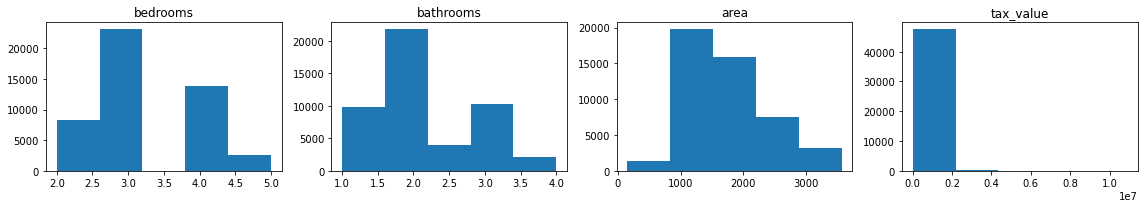

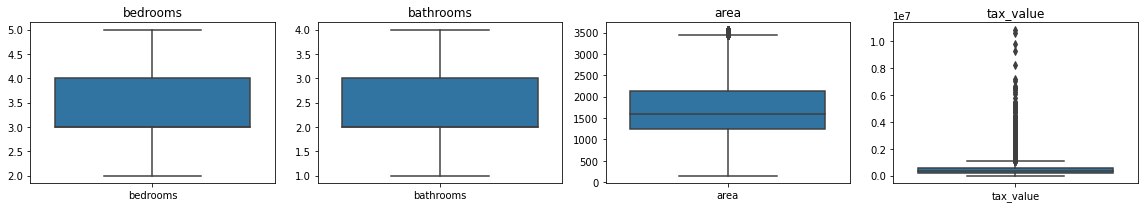

In [7]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prepare_zillow(df2, 'tax_value', ['bedrooms', 'bathrooms','area'])

In [8]:
train.shape, validate.shape, test.shape

((26773, 4), (11475, 4), (9562, 4))

In [9]:
train.isnull().any()

bedrooms     False
bathrooms    False
area         False
tax_value    False
dtype: bool

In [10]:
X_train

,bedrooms,bathrooms,area
20297,0.333333,0.333333,0.240518
11077,0.000000,0.000000,0.121492
3536,0.333333,0.666667,0.761640
50030,0.333333,0.666667,0.673451
36696,0.666667,0.833333,0.996608
...,...,...,...
38633,0.333333,0.000000,0.263336
27758,0.333333,0.500000,0.533457
12603,0.000000,0.333333,0.387912
43705,0.666667,0.333333,0.567684


In [11]:
y_train

20297    165920.0
11077     71313.0
3536     497916.0
50030    216470.0
36696    924092.0
           ...   
38633     48905.0
27758    774558.0
12603    716200.0
43705    556524.0
50941    350420.0
Name: tax_value, Length: 26773, dtype: float64

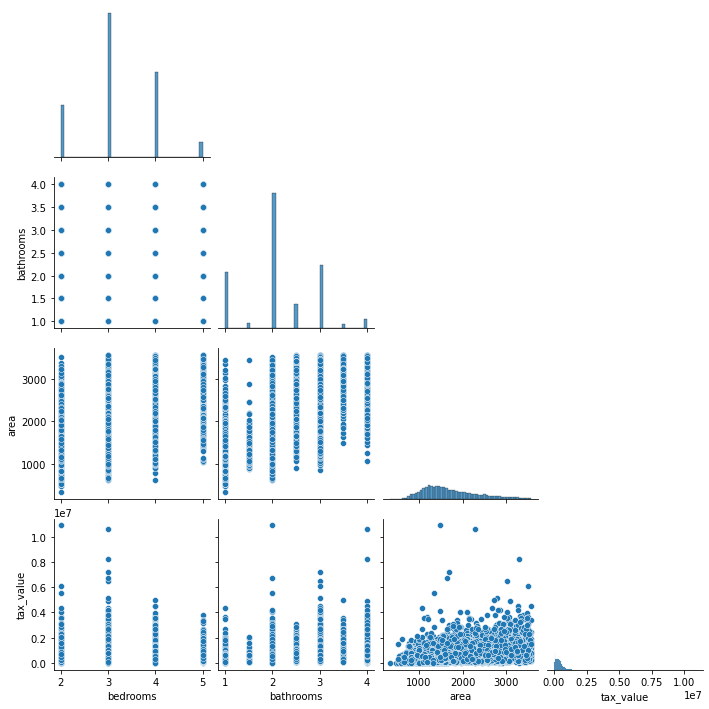

In [12]:
sns.pairplot(data=train, corner=True)
plt.show()

In [13]:
zillow_corr = train.corr(method='spearman')
zillow_corr

,bedrooms,bathrooms,area,tax_value
bedrooms,1.000000,0.571909,0.615108,0.206707
bathrooms,0.571909,1.000000,0.801455,0.402517
area,0.615108,0.801455,1.000000,0.450425
tax_value,0.206707,0.402517,0.450425,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

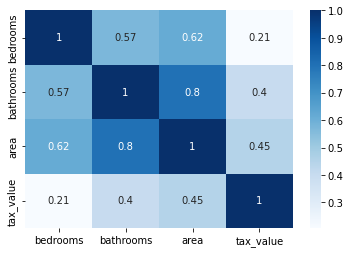

In [14]:
sns.heatmap(zillow_corr, cmap='Blues', annot=True)
plt.show

In [15]:
for col in train:
    print(col)
    r, p_value = stats.spearmanr(train[col], y_train)

    print(f'Correlation Coefficient by Spearman Test: {r}\np-value: {p_value}')
    print()

    if p_value < 0.05:
        print('We can reject the null hypothesis')
        print()
    else:
        print('we cannot reject the null hypothesis')
        print()

bedrooms
Correlation Coefficient by Spearman Test: 0.20670726698288353
p-value: 3.324960139419111e-256

We can reject the null hypothesis

bathrooms
Correlation Coefficient by Spearman Test: 0.40251715969962504
p-value: 0.0

We can reject the null hypothesis

area
Correlation Coefficient by Spearman Test: 0.45042451436050934
p-value: 0.0

We can reject the null hypothesis

tax_value
Correlation Coefficient by Spearman Test: 0.9999999999999999
p-value: 0.0

We can reject the null hypothesis



In [16]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [17]:
tax_value_mean = y_train['tax_value'].mean()
y_train['tax_value_mean'] = tax_value_mean
y_validate['tax_value_mean'] = tax_value_mean

In [18]:
y_train

,tax_value,tax_value_mean
20297,165920.0,434543.699399
11077,71313.0,434543.699399
3536,497916.0,434543.699399
50030,216470.0,434543.699399
36696,924092.0,434543.699399
...,...,...
38633,48905.0,434543.699399
27758,774558.0,434543.699399
12603,716200.0,434543.699399
43705,556524.0,434543.699399


In [19]:
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_mean) ** .5

print('RMSE using Mean\nTrain/In-Sample: ', round(rmse_train,2),
      '\nValidate/Out-of-Sample: ', round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  405904.68 
Validate/Out-of-Sample:  409288.61


In [20]:
metric_df = pd.DataFrame(
    data=[{
        'model': 'mean_baseline',
        'rmse': rmse_validate,
        'r^2': explained_variance_score(y_validate.tax_value, y_validate.tax_value_mean)
    }])

In [21]:
metric_df

,model,rmse,r^2
0,mean_baseline,409288.612935,0.0


In [22]:
metric_df = evaluate.model_metrics(LinearRegression(), X_train, y_train, X_validate, y_validate, metric_df)

Name for model? LinearRegression


In [23]:
metric_df

,model,rmse,r^2
0,mean_baseline,409288.612935,0.000000
1,LinearRegression,368403.390666,0.189808


In [24]:
metric_df = evaluate.model_metrics(LassoLars(alpha=1), X_train, y_train, X_validate, y_validate, metric_df)

Name for model? Lasso


In [25]:
metric_df

,model,rmse,r^2
0,mean_baseline,409288.612935,0.000000
1,LinearRegression,368403.390666,0.189808
2,Lasso,368396.998575,0.189836


In [26]:
metric_df = evaluate.model_metrics(TweedieRegressor(power = 2, alpha = 0), X_train, y_train, X_validate, y_validate, metric_df)

Name for model? GLM_power_2


In [27]:
metric_df

,model,rmse,r^2
0,mean_baseline,409288.612935,0.000000
1,LinearRegression,368403.390666,0.189808
2,Lasso,368396.998575,0.189836
3,GLM_power_2,366469.929790,0.198301


In [28]:
pf = PolynomialFeatures(degree = 2)

X_train_d2 = pf.fit_transform(X_train)

X_validate_d2 = pf.transform(X_validate)

In [29]:
lm2 = LinearRegression(normalize=True)

lm2.fit(X_train_d2, y_train.tax_value)

LinearRegression(normalize=True)

In [30]:
in_sample_pred = lm2.predict(X_train_d2)
out_sample_pred = lm2.predict(X_validate_d2)
model_name = input('Name for model?')
y_train[model_name] = in_sample_pred
y_validate[model_name] = out_sample_pred
 
rmse_val = mean_squared_error(
y_validate['tax_value'], out_sample_pred, squared=False)
r_squared_val = explained_variance_score(
        y_validate['tax_value'], out_sample_pred)
metric_df = metric_df.append({
        'model': model_name,
        'rmse': rmse_val,
        'r^2': r_squared_val
    }, ignore_index=True)

Name for model? Quadratic_Model


In [31]:
metric_df

,model,rmse,r^2
0,mean_baseline,409288.612935,0.000000
1,LinearRegression,368403.390666,0.189808
2,Lasso,368396.998575,0.189836
3,GLM_power_2,366469.929790,0.198301
4,Quadratic_Model,366036.592065,0.200205
